In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

In [2]:
df=pd.read_csv('data.csv') # load csv to dataframe
print(df.shape)
df.head()

(1878, 9)


,Unnamed: 0,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
0,0,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
1,1,2022-02-09,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2,2,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
3,3,2022-02-09,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
4,4,2022-02-09,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84


In [3]:
# cast columns to correct dtypes and make some additional features
df['purchase_price']=pd.to_numeric(df['purchase_price'])
df['suggested_retail_price']=pd.to_numeric(df['suggested_retail_price'])
df['orders_quantity']=pd.to_numeric(df['orders_quantity'])
df['sales_quantity']=pd.to_numeric(df['sales_quantity'])
df['revenue']=pd.to_numeric(df['revenue'])
df['date']=pd.to_datetime(df['day'])

df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['weekday']=df['date'].dt.day_name()
df['year']=df['date'].dt.year
df=df.sort_values(by='date')
df.replace([np.inf, -np.inf], 0, inplace=True)

print(df.shape)
df.head()

(1878, 13)


,Unnamed: 0,day,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,date,month,weekday,year
1877,1877,3,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,23.0,22.77,2021-04-03,4,Saturday,2021
1872,1872,3,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,40.0,17.0,25.33,2021-04-03,4,Saturday,2021
1873,1873,3,80317483,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,40.0,17.0,25.33,2021-04-03,4,Saturday,2021
1876,1876,3,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,23.0,22.77,2021-04-03,4,Saturday,2021
1875,1875,3,80101923,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,2.0,5.98,2021-04-03,4,Saturday,2021


In [4]:
drop_columns=['Unnamed: 0', 'item_number', 'date'] # drop unneccassry columns
df1=df.drop(drop_columns,axis=1)
df1.head()

,day,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,month,weekday,year
1877,3,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,23.0,22.77,4,Saturday,2021
1872,3,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,40.0,17.0,25.33,4,Saturday,2021
1873,3,ROMA TOMATEN ES I 500G SF,0.978451,1.546338,40.0,17.0,25.33,4,Saturday,2021
1876,3,UH ZWIEBELN DE-HE I 1KG GS,0.674928,1.055314,0.0,23.0,22.77,4,Saturday,2021
1875,3,SL MANDARINEN BEH.ES I 750G GS,1.991321,3.216415,0.0,2.0,5.98,4,Saturday,2021


In [5]:
df1.isna().sum()

day                         0
item_name                   0
purchase_price              0
suggested_retail_price      0
orders_quantity             0
sales_quantity              0
revenue                   952
month                       0
weekday                     0
year                        0
dtype: int64

In [6]:
df1.fillna(0, inplace=True) # replace nans of revenue with 0 (tried imputing with mean but didn't work well)
df1.isna().sum()

day                       0
item_name                 0
purchase_price            0
suggested_retail_price    0
orders_quantity           0
sales_quantity            0
revenue                   0
month                     0
weekday                   0
year                      0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
le={}
cols_to_encode=['item_name', 'weekday'] # encode the non-numeric columns 
for col in cols_to_encode:
    le[col]=LabelEncoder()
    df1[col]=le[col].fit_transform(df1[col])
df1.head()

,day,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue,month,weekday,year
1877,3,2,0.674928,1.055314,0.0,23.0,22.77,4,2,2021
1872,3,0,0.978451,1.546338,40.0,17.0,25.33,4,2,2021
1873,3,0,0.978451,1.546338,40.0,17.0,25.33,4,2,2021
1876,3,2,0.674928,1.055314,0.0,23.0,22.77,4,2,2021
1875,3,1,1.991321,3.216415,0.0,2.0,5.98,4,2,2021


In [8]:
unique_items=df1.item_name.unique() # unique items

In [9]:
# make features and labels in a rolling window fashion (prev 1 row is feature and then next one is label)
from tqdm import tqdm

# it is possible to do this like "df.iloc[::2, :]" without loops but was unable to make that work in limited time

features=[]
labels=[]

with tqdm(total=len(unique_items)) as pbar:
    for item in unique_items:
        df2=df1.loc[df1['item_name']==item] # select all values for an item
        df2=df2.drop_duplicates()
        feature_flag=True
        for i,row in df2.iterrows():
            if feature_flag:
                sublist=[row['day'],row['item_name'],row['purchase_price'],row['suggested_retail_price'],
                    row['orders_quantity'],row['revenue'],row['month'],row['weekday'],row['year'],row['sales_quantity']]
                feature_flag=False
                continue
            else:
                features.append(sublist)
                labels.append(row['sales_quantity'])
                sublist=[]
                feature_flag=True
        pbar.update(1)

100%|██████████| 3/3 [00:00<00:00, 36.11it/s]


In [10]:
features=np.array(features)
labels=np.array(labels)
print(labels.shape)
features.shape

(468,)


(468, 10)

In [11]:
print(features[10:12])
labels[10:12]

[[2.30000000e+01 2.00000000e+00 6.30000000e-01 9.90000000e-01
  1.80000000e+01 3.35400000e+01 4.00000000e+00 0.00000000e+00
  2.02100000e+03 3.40000000e+01]
 [2.50000000e+01 2.00000000e+00 6.74927536e-01 1.05531401e+00
  0.00000000e+00 0.00000000e+00 4.00000000e+00 3.00000000e+00
  2.02100000e+03 0.00000000e+00]]


array([22., 16.])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.33, random_state=42,shuffle=True)

In [13]:
X_train.shape

(313, 10)

In [14]:
y_train.shape

(313,)

In [15]:
from sklearn.ensemble import RandomForestRegressor # fit a model
clf=RandomForestRegressor(50,n_jobs=-1)
clf.fit(X_train,y_train)
preds=clf.predict(X_test)
clf.score(X_test,y_test)

0.6643076190934281

In [16]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,preds))

4.32941935483871


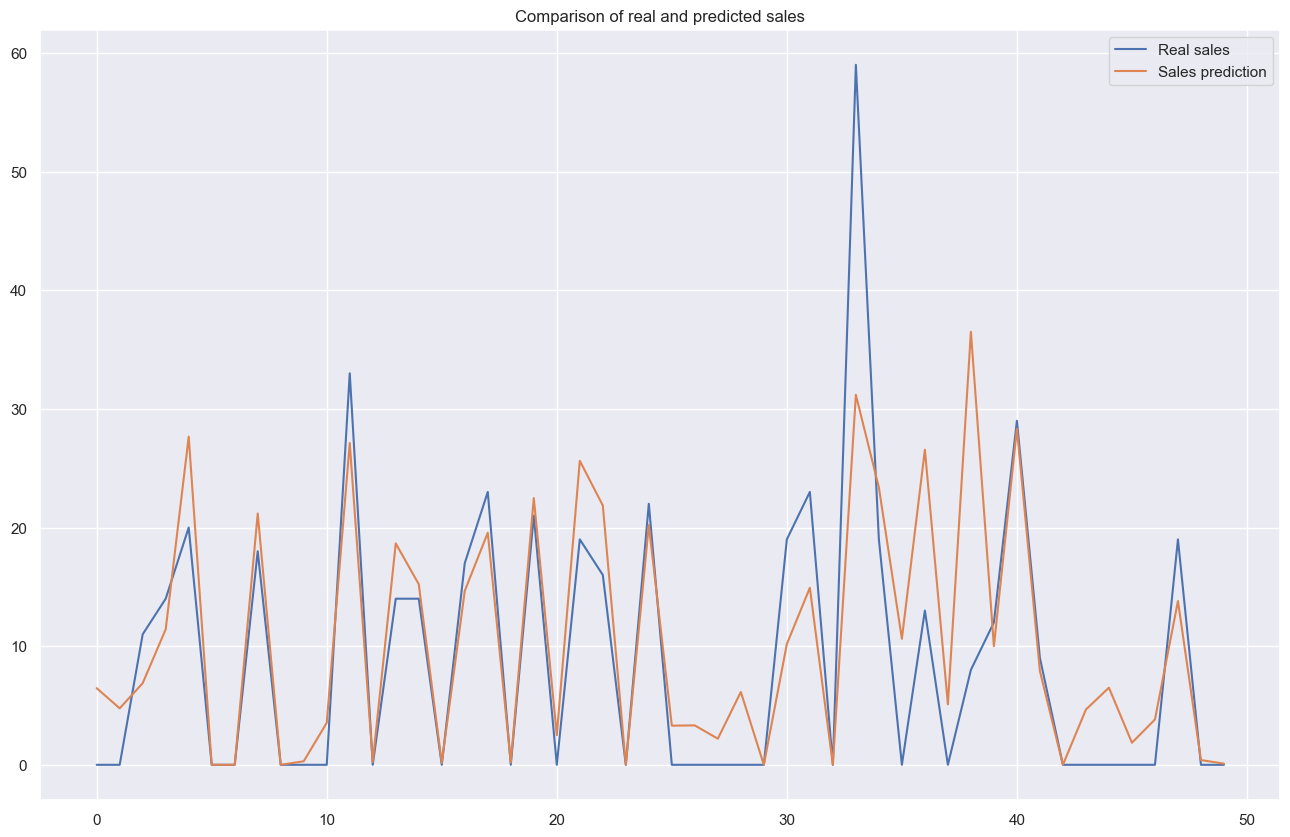

In [17]:
plt.figure(figsize=(16,10))
plt.plot(y_test[:50], label="Real sales")
plt.plot(preds[:50], label="Sales prediction")
plt.legend()
plt.title("Comparison of real and predicted sales")
plt.show()

In [18]:
feature_names=['day','item_name','purchase_price','suggested_retail_price','orders_quantity','revenue',
               'month','weekday','year','sales_quantity']

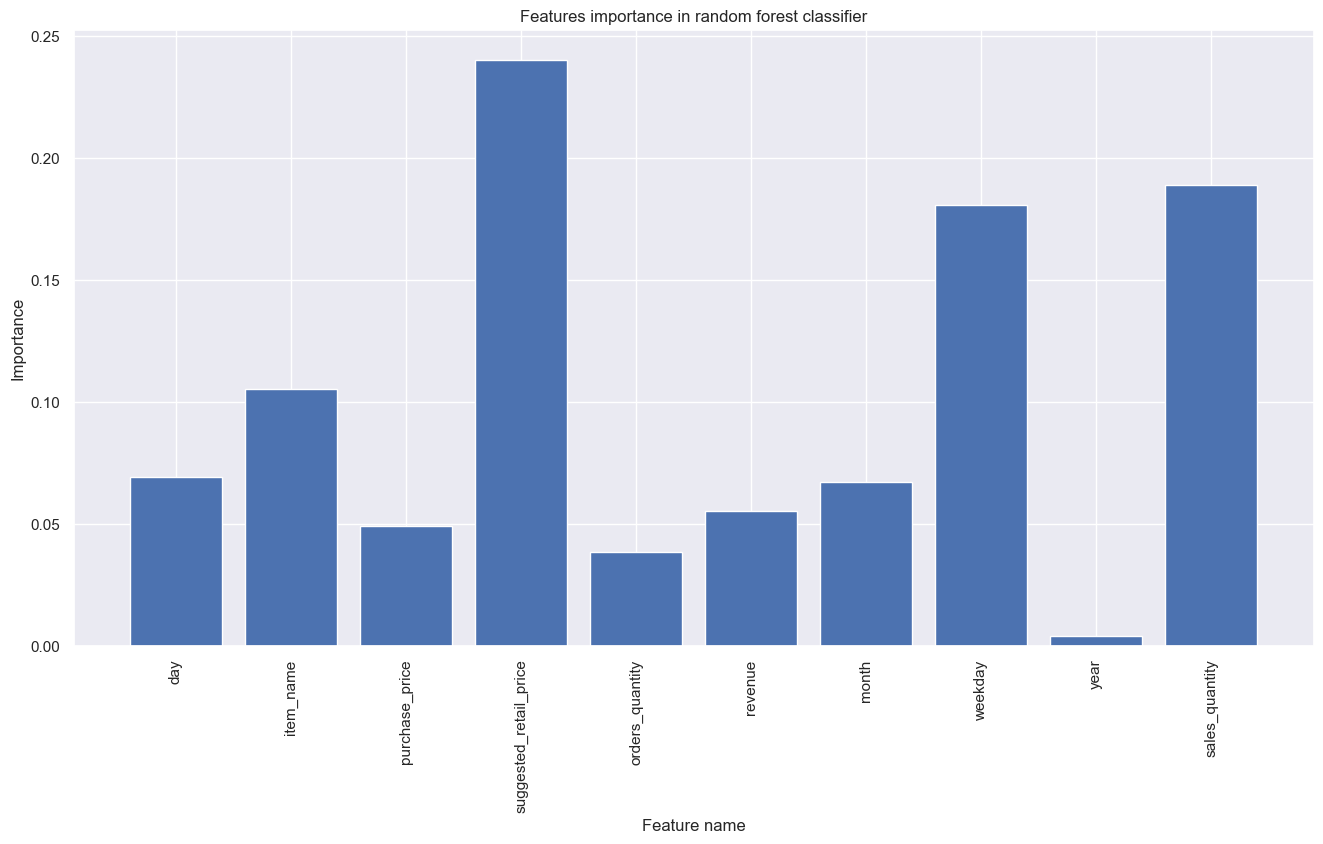

In [19]:
imp=clf.feature_importances_
plt.figure(figsize=(16,8))
plt.bar(feature_names,clf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Features importance in random forest classifier") # show feature importances
plt.xlabel("Feature name")
plt.ylabel("Importance")
plt.show()

In [37]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

In [38]:
X_test=scaler.transform(X_test)

In [39]:
X_train=np.reshape(X_train,(len(X_train),1,10))
X_test=np.reshape(X_test,(len(X_test),1,10))

In [40]:
# LSTM for forecasting

In [41]:
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam

inp = Input((1,10))

x=Bidirectional(LSTM(64,return_sequences=True))(inp)
x = Dropout(0.2)(x)
x=LSTM(16)(x)
x=Flatten()(x)
x = Dropout(0.2)(x)

x = Dense(512,activation='relu', name='feats')(x) 

out1 = Dense(1,activation='linear')(x)

model = Model(inp, out1)
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 1, 128)           38400     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                9280      
                                                                 
 flatten_6 (Flatten)         (None, 16)                0         
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                           

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer = 'adam', loss = 'mse')

history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test), shuffle=True, epochs=1000, batch_size=32)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/10 [==>...........................] - ETA: 32s - loss: 225.5359WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x13d228e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full o

10/10 [==============================] - 0s 7ms/step - loss: 120.1343 - val_loss: 227.4829
Epoch 62/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.8704 - val_loss: 228.2473
Epoch 63/1000
10/10 [==============================] - 0s 4ms/step - loss: 121.6137 - val_loss: 227.1668
Epoch 64/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.8291 - val_loss: 227.4239
Epoch 65/1000
10/10 [==============================] - 0s 4ms/step - loss: 119.9609 - val_loss: 226.0668
Epoch 66/1000
10/10 [==============================] - 0s 4ms/step - loss: 121.7553 - val_loss: 225.8866
Epoch 67/1000
10/10 [==============================] - 0s 4ms/step - loss: 123.2644 - val_loss: 226.5246
Epoch 68/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.4682 - val_loss: 227.5969
Epoch 69/1000
10/10 [==============================] - 0s 4ms/step - loss: 121.4814 - val_loss: 226.3528
Epoch 70/1000
10/10 [==============================] - 0s 4ms/step - 

Epoch 139/1000
10/10 [==============================] - 0s 5ms/step - loss: 122.1228 - val_loss: 206.2863
Epoch 140/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.9388 - val_loss: 206.2802
Epoch 141/1000
10/10 [==============================] - 0s 4ms/step - loss: 121.4214 - val_loss: 207.0722
Epoch 142/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.9132 - val_loss: 206.6390
Epoch 143/1000
10/10 [==============================] - 0s 4ms/step - loss: 119.5448 - val_loss: 205.4793
Epoch 144/1000
10/10 [==============================] - 0s 5ms/step - loss: 122.0636 - val_loss: 206.5432
Epoch 145/1000
10/10 [==============================] - 0s 4ms/step - loss: 121.0662 - val_loss: 205.8237
Epoch 146/1000
10/10 [==============================] - 0s 4ms/step - loss: 120.9206 - val_loss: 205.8876
Epoch 147/1000
10/10 [==============================] - 0s 4ms/step - loss: 122.5732 - val_loss: 205.6681
Epoch 148/1000
10/10 [========================

10/10 [==============================] - 0s 4ms/step - loss: 92.5737 - val_loss: 189.4235
Epoch 217/1000
10/10 [==============================] - 0s 4ms/step - loss: 94.5493 - val_loss: 189.8662
Epoch 218/1000
10/10 [==============================] - 0s 4ms/step - loss: 87.6327 - val_loss: 187.2310
Epoch 219/1000
10/10 [==============================] - 0s 4ms/step - loss: 93.7825 - val_loss: 187.7470
Epoch 220/1000
10/10 [==============================] - 0s 4ms/step - loss: 91.1895 - val_loss: 188.4618
Epoch 221/1000
10/10 [==============================] - 0s 4ms/step - loss: 105.9400 - val_loss: 188.5933
Epoch 222/1000
10/10 [==============================] - 0s 4ms/step - loss: 99.9129 - val_loss: 188.9495
Epoch 223/1000
10/10 [==============================] - 0s 4ms/step - loss: 96.0000 - val_loss: 188.1775
Epoch 224/1000
10/10 [==============================] - 0s 4ms/step - loss: 87.7242 - val_loss: 188.9599
Epoch 225/1000
10/10 [==============================] - 0s 4ms/step -

10/10 [==============================] - 0s 4ms/step - loss: 85.3629 - val_loss: 181.0017
Epoch 295/1000
10/10 [==============================] - 0s 4ms/step - loss: 98.3119 - val_loss: 180.2850
Epoch 296/1000
10/10 [==============================] - 0s 4ms/step - loss: 93.3158 - val_loss: 180.8930
Epoch 297/1000
10/10 [==============================] - 0s 4ms/step - loss: 76.3858 - val_loss: 180.4580
Epoch 298/1000
10/10 [==============================] - 0s 4ms/step - loss: 86.2993 - val_loss: 180.3410
Epoch 299/1000
10/10 [==============================] - 0s 5ms/step - loss: 88.8163 - val_loss: 180.5173
Epoch 300/1000
10/10 [==============================] - 0s 4ms/step - loss: 90.3911 - val_loss: 180.7913
Epoch 301/1000
10/10 [==============================] - 0s 4ms/step - loss: 88.6648 - val_loss: 181.4083
Epoch 302/1000
10/10 [==============================] - 0s 4ms/step - loss: 86.0986 - val_loss: 180.3904
Epoch 303/1000
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 80.9964 - val_loss: 179.2403
Epoch 373/1000
10/10 [==============================] - 0s 4ms/step - loss: 78.7959 - val_loss: 179.5756
Epoch 374/1000
10/10 [==============================] - 0s 4ms/step - loss: 90.3017 - val_loss: 179.7541
Epoch 375/1000
10/10 [==============================] - 0s 4ms/step - loss: 94.5135 - val_loss: 179.3939
Epoch 376/1000
10/10 [==============================] - 0s 4ms/step - loss: 93.6478 - val_loss: 180.2148
Epoch 377/1000
10/10 [==============================] - 0s 4ms/step - loss: 84.5673 - val_loss: 179.7661
Epoch 378/1000
10/10 [==============================] - 0s 4ms/step - loss: 79.7211 - val_loss: 178.7161
Epoch 379/1000
10/10 [==============================] - 0s 4ms/step - loss: 93.1022 - val_loss: 178.1575
Epoch 380/1000
10/10 [==============================] - 0s 4ms/step - loss: 91.2205 - val_loss: 178.5703
Epoch 381/1000
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 80.6361 - val_loss: 177.5869
Epoch 451/1000
10/10 [==============================] - 0s 5ms/step - loss: 85.8349 - val_loss: 177.3340
Epoch 452/1000
10/10 [==============================] - 0s 5ms/step - loss: 88.2712 - val_loss: 177.7429
Epoch 453/1000
10/10 [==============================] - 0s 5ms/step - loss: 85.3046 - val_loss: 178.4476
Epoch 454/1000
10/10 [==============================] - 0s 5ms/step - loss: 89.2144 - val_loss: 178.7445
Epoch 455/1000
10/10 [==============================] - 0s 5ms/step - loss: 90.3955 - val_loss: 178.1708
Epoch 456/1000
10/10 [==============================] - 0s 5ms/step - loss: 92.1921 - val_loss: 177.7937
Epoch 457/1000
10/10 [==============================] - 0s 5ms/step - loss: 87.2404 - val_loss: 177.9807
Epoch 458/1000
10/10 [==============================] - 0s 5ms/step - loss: 90.8082 - val_loss: 177.5830
Epoch 459/1000
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 83.8955 - val_loss: 176.3056
Epoch 529/1000
10/10 [==============================] - 0s 5ms/step - loss: 102.8452 - val_loss: 175.7799
Epoch 530/1000
10/10 [==============================] - 0s 5ms/step - loss: 88.1668 - val_loss: 175.6083
Epoch 531/1000
10/10 [==============================] - 0s 5ms/step - loss: 89.6067 - val_loss: 175.7664
Epoch 532/1000
10/10 [==============================] - 0s 5ms/step - loss: 91.0890 - val_loss: 175.7875
Epoch 533/1000
10/10 [==============================] - 0s 5ms/step - loss: 90.0908 - val_loss: 175.6613
Epoch 534/1000
10/10 [==============================] - 0s 5ms/step - loss: 85.7038 - val_loss: 176.1445
Epoch 535/1000
10/10 [==============================] - 0s 4ms/step - loss: 99.7842 - val_loss: 175.9249
Epoch 536/1000
10/10 [==============================] - 0s 4ms/step - loss: 95.6910 - val_loss: 175.9388
Epoch 537/1000
10/10 [==============================] - 0s 4ms/step -

10/10 [==============================] - 0s 5ms/step - loss: 91.0591 - val_loss: 177.0527
Epoch 607/1000
10/10 [==============================] - 0s 5ms/step - loss: 82.5098 - val_loss: 177.1696
Epoch 608/1000
10/10 [==============================] - 0s 4ms/step - loss: 89.7341 - val_loss: 177.2503
Epoch 609/1000
10/10 [==============================] - 0s 4ms/step - loss: 85.1506 - val_loss: 176.6717
Epoch 610/1000
10/10 [==============================] - 0s 4ms/step - loss: 82.4576 - val_loss: 176.6244
Epoch 611/1000
10/10 [==============================] - 0s 4ms/step - loss: 85.5946 - val_loss: 176.5019
Epoch 612/1000
10/10 [==============================] - 0s 4ms/step - loss: 91.4842 - val_loss: 176.3475
Epoch 613/1000
10/10 [==============================] - 0s 4ms/step - loss: 88.8326 - val_loss: 176.2409
Epoch 614/1000
10/10 [==============================] - 0s 4ms/step - loss: 86.3529 - val_loss: 175.6743
Epoch 615/1000
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 91.5497 - val_loss: 176.4926
Epoch 685/1000
10/10 [==============================] - 0s 5ms/step - loss: 83.7605 - val_loss: 176.2739
Epoch 686/1000
10/10 [==============================] - 0s 5ms/step - loss: 96.6141 - val_loss: 175.7894
Epoch 687/1000
10/10 [==============================] - 0s 5ms/step - loss: 89.3933 - val_loss: 177.7202
Epoch 688/1000
10/10 [==============================] - 0s 4ms/step - loss: 85.2492 - val_loss: 177.4402
Epoch 689/1000
10/10 [==============================] - 0s 5ms/step - loss: 83.1911 - val_loss: 176.7053
Epoch 690/1000
10/10 [==============================] - 0s 5ms/step - loss: 88.5730 - val_loss: 176.5773
Epoch 691/1000
10/10 [==============================] - 0s 4ms/step - loss: 89.5912 - val_loss: 176.1712
Epoch 692/1000
10/10 [==============================] - 0s 5ms/step - loss: 94.2617 - val_loss: 175.9938
Epoch 693/1000
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 85.7067 - val_loss: 175.8289
Epoch 763/1000
10/10 [==============================] - 0s 5ms/step - loss: 90.6601 - val_loss: 175.5607
Epoch 764/1000
10/10 [==============================] - 0s 4ms/step - loss: 75.9393 - val_loss: 175.5373
Epoch 765/1000
10/10 [==============================] - 0s 4ms/step - loss: 81.7134 - val_loss: 175.2609
Epoch 766/1000
10/10 [==============================] - 0s 4ms/step - loss: 92.0266 - val_loss: 175.4888
Epoch 767/1000
10/10 [==============================] - 0s 4ms/step - loss: 84.6803 - val_loss: 175.2995
Epoch 768/1000
10/10 [==============================] - 0s 4ms/step - loss: 99.6857 - val_loss: 175.1943
Epoch 769/1000
10/10 [==============================] - 0s 4ms/step - loss: 82.8825 - val_loss: 174.9643
Epoch 770/1000
10/10 [==============================] - 0s 4ms/step - loss: 78.0985 - val_loss: 175.4343
Epoch 771/1000
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 79.8727 - val_loss: 175.5739
Epoch 841/1000
10/10 [==============================] - 0s 5ms/step - loss: 87.7478 - val_loss: 174.9746
Epoch 842/1000
10/10 [==============================] - 0s 5ms/step - loss: 83.5180 - val_loss: 174.7790
Epoch 843/1000
10/10 [==============================] - 0s 6ms/step - loss: 81.3994 - val_loss: 174.8537
Epoch 844/1000
10/10 [==============================] - 0s 4ms/step - loss: 84.7910 - val_loss: 174.7307
Epoch 845/1000
10/10 [==============================] - 0s 4ms/step - loss: 89.3177 - val_loss: 175.1471
Epoch 846/1000
10/10 [==============================] - 0s 4ms/step - loss: 78.4557 - val_loss: 175.1374
Epoch 847/1000
10/10 [==============================] - 0s 4ms/step - loss: 87.3468 - val_loss: 175.3326
Epoch 848/1000
10/10 [==============================] - 0s 4ms/step - loss: 84.9040 - val_loss: 175.1561
Epoch 849/1000
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 81.9190 - val_loss: 174.0974
Epoch 919/1000
10/10 [==============================] - 0s 5ms/step - loss: 86.5014 - val_loss: 173.9204
Epoch 920/1000
10/10 [==============================] - 0s 5ms/step - loss: 84.9134 - val_loss: 173.5738
Epoch 921/1000
10/10 [==============================] - 0s 4ms/step - loss: 86.0315 - val_loss: 173.4267
Epoch 922/1000
10/10 [==============================] - 0s 4ms/step - loss: 78.3370 - val_loss: 173.6152
Epoch 923/1000
10/10 [==============================] - 0s 4ms/step - loss: 75.9651 - val_loss: 173.3910
Epoch 924/1000
10/10 [==============================] - 0s 4ms/step - loss: 85.5453 - val_loss: 173.7709
Epoch 925/1000
10/10 [==============================] - 0s 5ms/step - loss: 93.9945 - val_loss: 173.1780
Epoch 926/1000
10/10 [==============================] - 0s 4ms/step - loss: 94.3716 - val_loss: 173.0113
Epoch 927/1000
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 5ms/step - loss: 85.6406 - val_loss: 173.2521
Epoch 997/1000
10/10 [==============================] - 0s 4ms/step - loss: 82.9370 - val_loss: 173.5758
Epoch 998/1000
10/10 [==============================] - 0s 4ms/step - loss: 85.2384 - val_loss: 173.6589
Epoch 999/1000
10/10 [==============================] - 0s 4ms/step - loss: 91.6472 - val_loss: 173.8411
Epoch 1000/1000
10/10 [==============================] - 0s 4ms/step - loss: 89.0975 - val_loss: 173.6028


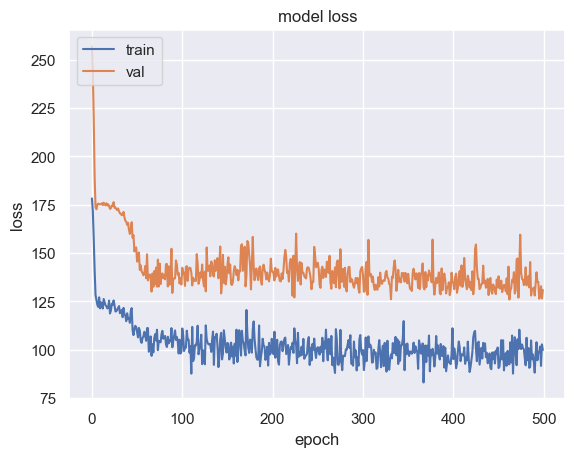

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()